In [176]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import math

torch.manual_seed(0)

In [177]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mu = torch.tensor(0.01)

In [178]:
class DeepONet(nn.Module):
    def __init__(self):
        super(DeepONet,self).__init__()
        self.Branch_L1 = nn.Linear(100,100)
        self.Branch_L2 = nn.Linear(100,100)
        self.Branch_L3 = nn.Linear(100,100)
        self.Branch_L4 = nn.Linear(100,100)
        self.Branch_L5 = nn.Linear(100,100)
        self.Branch_L6 = nn.Linear(100,100)
        self.Branch_L7 = nn.Linear(100,100)

        self.Trunk_L1 = nn.Linear(2,20)
        self.Trunk_L2 = nn.Linear(20,20)
        self.Trunk_L3 = nn.Linear(20,20)
        self.Trunk_L4 = nn.Linear(20,20)
        self.Trunk_L5 = nn.Linear(20,100)

    def forward(self,y_0,x_loc_and_time):
        # Branch
        b = F.tanh(self.Branch_L1(y_0))
        b = F.tanh(self.Branch_L2(b))
        b = F.tanh(self.Branch_L3(b))
        b = F.tanh(self.Branch_L4(b))
        b = F.tanh(self.Branch_L5(b))
        b = F.tanh(self.Branch_L6(b))
        b = self.Branch_L7(b)

        tr = F.tanh(self.Trunk_L1(x_loc_and_time))
        tr = F.tanh(self.Trunk_L2(tr))
        tr = F.tanh(self.Trunk_L3(tr))
        tr = F.tanh(self.Trunk_L4(tr))
        tr = self.Trunk_L5(tr)

        #output = torch.matmul(b,tr.t()).sum(dim=0)
        output = torch.sum(b * tr, dim=1)

        return output

model = DeepONet().to(device)

In [179]:
model = DeepONet().to(device)

In [180]:
database = pd.read_csv('sin_pix.csv',index_col=0).dropna().to_numpy(dtype='float32')

In [181]:
database.shape

(33000, 103)

In [182]:
class Data(Dataset):
    def __init__(self,transform=None):
        self.initial_conditions = torch.from_numpy(database[:,0:100])#.requires_grad_(True)
        self.x_location = torch.from_numpy(database[:,[100]])#.requires_grad_(True)
        self.time_vale = torch.from_numpy(database[:,[101]]).requires_grad_(True)
        self.true_y_value = torch.from_numpy(database[:,[102]])#.requires_grad_(True)
        self.n_samples = database.shape[0]

    def __getitem__(self, index):
        return self.initial_conditions[index] , self.x_location[index] , self.time_vale[index] , self.true_y_value[index]
    
    def __len__(self):
        return self.n_samples

In [183]:
dataset_data = Data()

In [184]:
dataset_data.__len__()

33000

In [185]:
y,_,_,_ = dataset_data.__getitem__(1)
#plt.plot(y)
#plt.grid()

In [186]:
train_size = int(0.6*dataset_data.__len__())
test_size = dataset_data.__len__() - train_size

batch_size = 500

Burger_train_data , Burger_test_data = torch.utils.data.random_split(Data(),[train_size,test_size])

train_loader = DataLoader(dataset=Burger_train_data,batch_size=batch_size,shuffle=True)

In [187]:
train_size

19800

In [188]:
data_iter = iter(train_loader)
data = data_iter.__next__()
Init_val , x_loc, time, y_value = data

In [189]:
num_epoch = 10
total_samples = len(train_loader)
n_iterations = math.ceil(total_samples/300)
print(total_samples,n_iterations)
learning_rate = 0.0000001

criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.00001)

loss_rec = []

40 1


In [190]:
def grad(outputs,inputs):
    return torch.autograd.grad(outputs,inputs,grad_outputs=torch.ones_like(outputs),create_graph=True)

In [191]:
x_locations_for_computation = torch.linspace(0,1,300,dtype=torch.float32).requires_grad_(True)

def Physics_loss_Burgers(init_conditions,time_input_physics,x_locations):
    total_temp = torch.tensor(0)
    for j in range(len(time_input_physics)):
        # Set up the input x locations as a range from 0 to 1
        # x_locations = torch.linspace(0,1,300,dtype=torch.float32).requires_grad_(True)

        # We will calculate gradients on every time given
        time_input = time_input_physics[j]*torch.ones_like(x_locations,dtype=torch.float32)

        # Taking the slice of the initial conditions associated with that time step. Can be used in future where not just sinx is taken.
        input_1_physics = init_conditions[j,:].unsqueeze(0)
        input2_physics = torch.cat((x_locations.unsqueeze(-1),time_input.unsqueeze(-1)),-1)

        # Getting output 
        output_physics = model(input_1_physics.expand(len(input2_physics),-1),input2_physics)

        # Getting required gradients
        du_dt = grad(output_physics,time_input)[0]
        du_dx = grad(output_physics,x_locations)[0]
        du2_dx2 = grad(du_dx,x_locations)[0]

        # Getting the physics loss and summing it up 
        temp = torch.mean(du_dt + output_physics*du_dx - mu*du2_dx2)
        total_temp = total_temp + temp

    return total_temp

In [192]:
x_locations = torch.linspace(0,1,300,dtype=torch.float32).requires_grad_(True)

In [193]:
time_input_physics = torch.tensor(0.2)
time_input = time_input_physics*torch.ones_like(x_locations,dtype=torch.float32).requires_grad_(True)
print(time_input)

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 

In [194]:
input2_physics = torch.cat((x_locations.unsqueeze(-1),time_input.unsqueeze(-1)),-1)
print(input2_physics)

tensor([[0.0000, 0.2000],
        [0.0033, 0.2000],
        [0.0067, 0.2000],
        [0.0100, 0.2000],
        [0.0134, 0.2000],
        [0.0167, 0.2000],
        [0.0201, 0.2000],
        [0.0234, 0.2000],
        [0.0268, 0.2000],
        [0.0301, 0.2000],
        [0.0334, 0.2000],
        [0.0368, 0.2000],
        [0.0401, 0.2000],
        [0.0435, 0.2000],
        [0.0468, 0.2000],
        [0.0502, 0.2000],
        [0.0535, 0.2000],
        [0.0569, 0.2000],
        [0.0602, 0.2000],
        [0.0635, 0.2000],
        [0.0669, 0.2000],
        [0.0702, 0.2000],
        [0.0736, 0.2000],
        [0.0769, 0.2000],
        [0.0803, 0.2000],
        [0.0836, 0.2000],
        [0.0870, 0.2000],
        [0.0903, 0.2000],
        [0.0936, 0.2000],
        [0.0970, 0.2000],
        [0.1003, 0.2000],
        [0.1037, 0.2000],
        [0.1070, 0.2000],
        [0.1104, 0.2000],
        [0.1137, 0.2000],
        [0.1171, 0.2000],
        [0.1204, 0.2000],
        [0.1237, 0.2000],
        [0.1

In [195]:
#input_1_physics = input1[1,:].unsqueeze(0)
#input_1_physics.shape

In [196]:
#output_physics = model(input_1_physics,input2_physics)

In [197]:
#du_dt = grad(output_physics,time_input)[0]
#du_dx = grad(output_physics,x_locations)[0]
#du2_dx2 = grad(du_dx,x_locations)[0]
#loss_physics_burgers = torch.mean(du_dt + x_locations*du_dx - mu*du2_dx2)
#loss_physics_burgers

In [198]:
#input1[3]

In [199]:
#Physics_loss_rec = Physics_loss(input1,input_time[3])
#Physics_loss_rec

In [200]:
model.train()

for epoch in range(num_epoch):
    for i , (input_init_conditions,input_x_loc,input_time,Actual_y) in enumerate(train_loader):
        input1 = input_init_conditions
        input1 = input1.to(device)

        input2 = torch.cat((input_x_loc,input_time),-1)
        input2 = input2.to(device)

        Actual_y = Actual_y.to(device)
        input_time.to(device)

        Outputs = model(input1,input2)

        #input2_BC1 = torch.cat((torch.zeros(input_time.size(0),1),input_time),-1).to(device)
        #target_BC1 = torch.zeros(input_time.size(0),device=device)#.to(device)
        #predicted_BC1 = model(input1,input2_BC1)
        #loss_BC1 = torch.mean((predicted_BC1-target_BC1)**2)

        #input2_BC2 = torch.cat((torch.ones(input_time.size(0),1),input_time),-1).to(device)
        #target_BC2 = torch.zeros(input_time.size(0),device=device) #.to(device)
        #predicted_BC2 = model(input1,input2_BC2)
        #loss_BC2 = torch.mean((predicted_BC2-target_BC2)**2)

        #Physics_loss = Physics_loss_Burgers(input1,input_time,x_locations_for_computation)
        
        loss = criterion(Outputs.unsqueeze(-1),Actual_y)  + (loss_BC1 + loss_BC2) + # 0.01*Physics_loss.abs()
        
        loss.backward()
        optimiser.step()    
        optimiser.zero_grad()
        loss_rec.append(loss.item())

        if (i+1) % 10 ==0:
            print(f'Epoch [{epoch+1}/{num_epoch}] , Step [{i+1}/{total_samples}] , Loss: {loss.item():.16f} , Physics loss : {Physics_loss.item():.16f}')
            #y_locations_test = model(input1[1],input2_physics)
            #plt.plot(x_locations.detach().numpy(),y_locations_test.detach().numpy())

Epoch [1/10] , Step [10/40] , Loss: 0.5824672579765320 , Physics loss : -0.2503941059112549
Epoch [1/10] , Step [20/40] , Loss: 0.5908364653587341 , Physics loss : 0.2129090875387192
Epoch [1/10] , Step [30/40] , Loss: 0.5631366968154907 , Physics loss : -0.1058596968650818
Epoch [1/10] , Step [40/40] , Loss: 0.5330834984779358 , Physics loss : -0.0061876056715846
Epoch [2/10] , Step [10/40] , Loss: 0.5270480513572693 , Physics loss : -0.0147858234122396
Epoch [2/10] , Step [20/40] , Loss: 0.5277228951454163 , Physics loss : 0.0910220071673393
Epoch [2/10] , Step [30/40] , Loss: 0.5285397171974182 , Physics loss : 0.0224484708160162
Epoch [2/10] , Step [40/40] , Loss: 0.5243427753448486 , Physics loss : -0.0133449127897620
Epoch [3/10] , Step [10/40] , Loss: 0.5302234888076782 , Physics loss : 0.0105220610275865
Epoch [3/10] , Step [20/40] , Loss: 0.5118844509124756 , Physics loss : -0.0302715096622705
Epoch [3/10] , Step [30/40] , Loss: 0.5013914108276367 , Physics loss : -0.131170138

In [201]:
Outputs.size()

torch.Size([300])

In [202]:
y_locations_test = model(input1[1].expand(len(input2_physics),-1),input2_physics.to(device))

In [203]:
input1[1].expand(100,-1)

tensor([[-1.2246e-16, -6.3424e-02, -1.2659e-01,  ...,  1.2659e-01,
          6.3424e-02,  1.2246e-16],
        [-1.2246e-16, -6.3424e-02, -1.2659e-01,  ...,  1.2659e-01,
          6.3424e-02,  1.2246e-16],
        [-1.2246e-16, -6.3424e-02, -1.2659e-01,  ...,  1.2659e-01,
          6.3424e-02,  1.2246e-16],
        ...,
        [-1.2246e-16, -6.3424e-02, -1.2659e-01,  ...,  1.2659e-01,
          6.3424e-02,  1.2246e-16],
        [-1.2246e-16, -6.3424e-02, -1.2659e-01,  ...,  1.2659e-01,
          6.3424e-02,  1.2246e-16],
        [-1.2246e-16, -6.3424e-02, -1.2659e-01,  ...,  1.2659e-01,
          6.3424e-02,  1.2246e-16]])

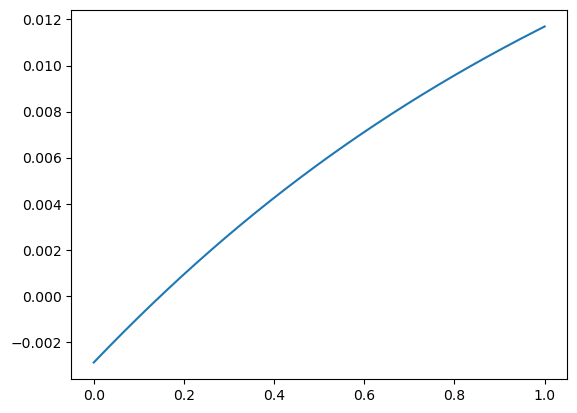

In [204]:
plt.plot(x_locations.cpu().detach().numpy(),y_locations_test.cpu().detach().numpy())        

In [205]:
input_time.size(0)

300

In [206]:
input2_BC1 = torch.cat((torch.zeros(input_time.size(0),1),input_time),-1).to(device)

In [207]:
target_BC1 = torch.zeros(input_time.size(0))

In [208]:
input2.size()

torch.Size([300, 2])

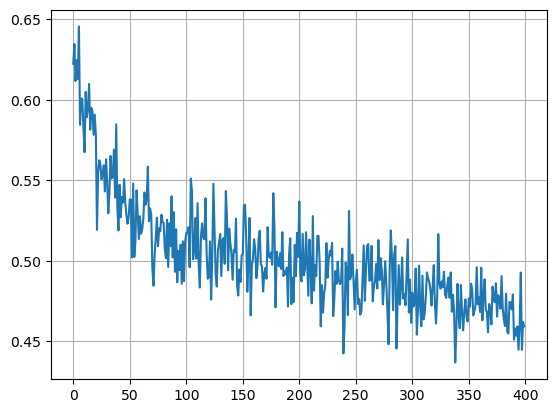

In [209]:
plt.plot(loss_rec)#[1000:])
plt.grid()

In [210]:
# model(y,torch.tensor([0,0]))

In [211]:
trial_input_1 = torch.tensor(np.random.rand(65,100),dtype=torch.float32).to(device)
trial_input_2 = torch.tensor(np.random.rand(65,2),dtype=torch.float32).to(device)
model(trial_input_1,trial_input_2).mean()
model(trial_input_1,trial_input_2).shape

torch.Size([65])